In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
from numpy import cos
from scipy.spatial import cKDTree

In [3]:
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline
import skimage.io
import cv2

In [4]:
LSLGAdir = os.getenv('LSLGA_DIR')
parent = os.path.join(LSLGAdir, 'sample', 'large-galaxies-parent.fits')
tycho2 = os.path.join(LSLGAdir, 'sample', 'tycho2.kd.fits')

In [5]:
galaxies = Table(fitsio.read(parent, ext=1)).to_pandas()
tycho = Table(fitsio.read(tycho2, ext=1)).to_pandas()

In [6]:
ramod = tycho.RA * cos(tycho.DEC)
locations = np.array([ramod, tycho.DEC]).T
tree = cKDTree(locations)

In [7]:
nearby = []
for gal in galaxies.itertuples():

    ra = gal.ra
    dec = gal.dec

    point = (ra * cos(dec), dec)
    near_list = tree.query_ball_point(point, np.degrees(2*(1/3600)))
    nearby.append(near_list)
    
nearby = np.array(nearby)

In [8]:
indices = []
groups = []
for ii, stars in enumerate(nearby):
    if len(stars) > 0:
        indices.append(ii)
        groups.append(stars)

In [9]:
check = galaxies.loc[indices]

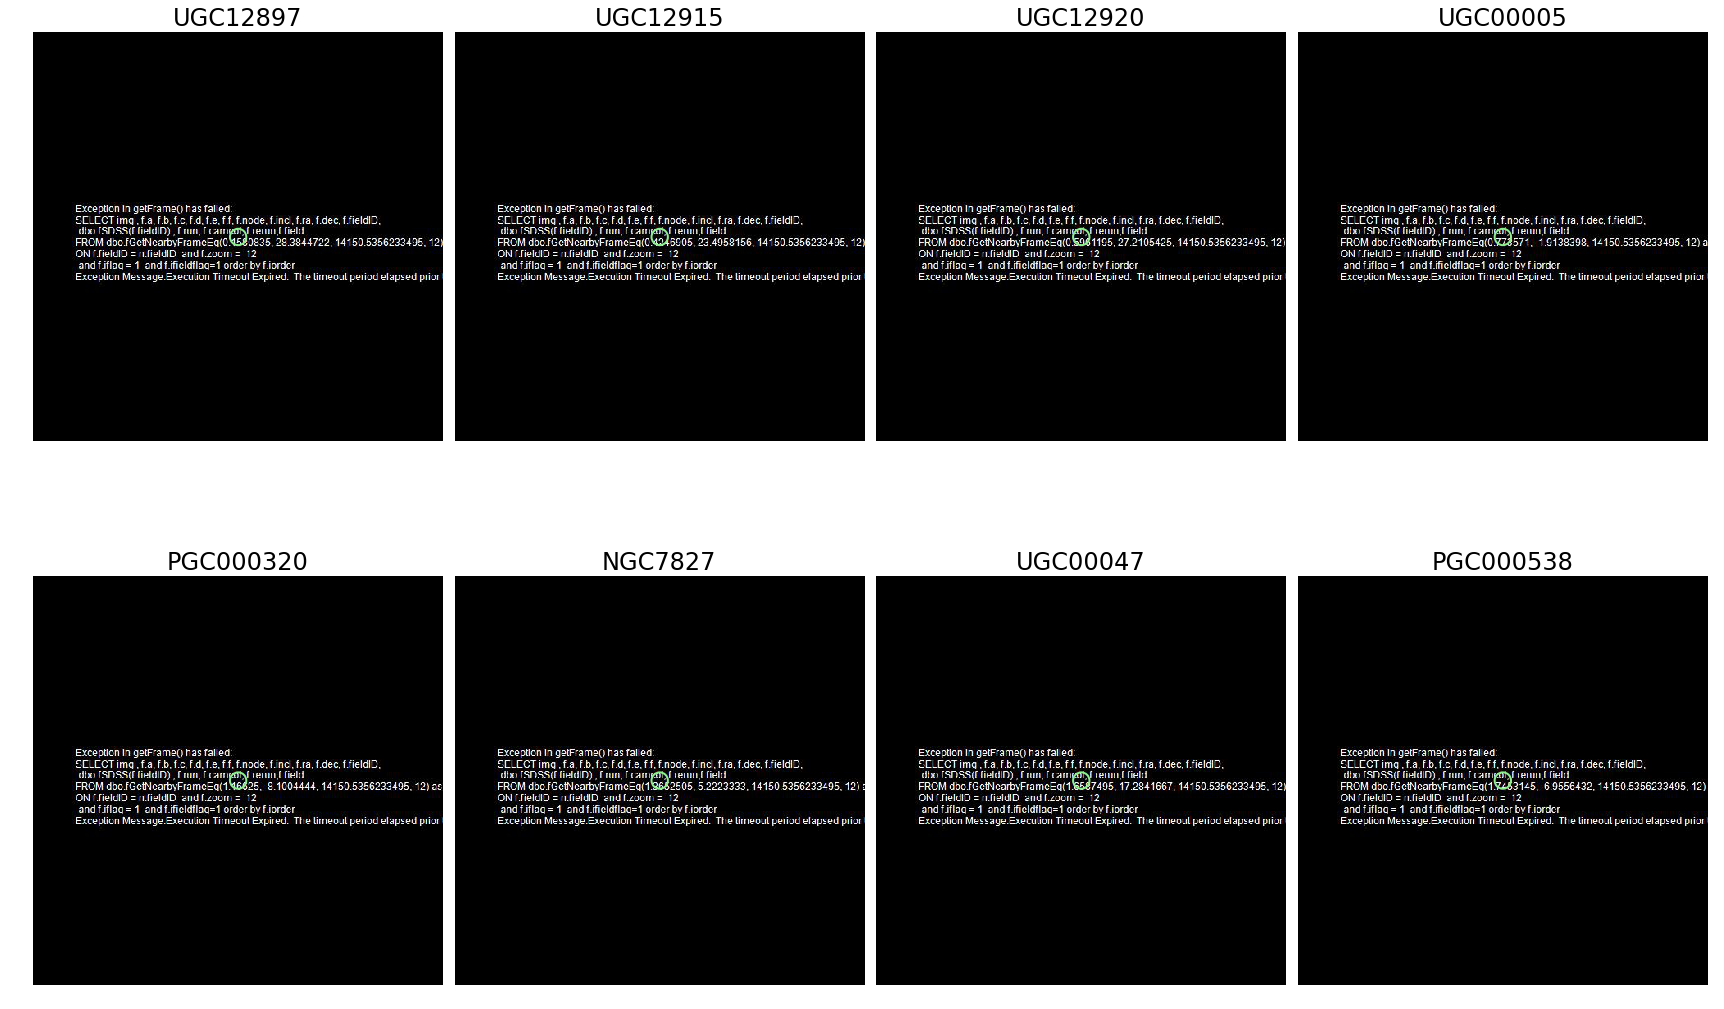

In [12]:
sample = check[:8]

width = 500
height = 500
pixelsize = 0.5 #0.396
plt.figure(figsize=(30, 2.5*len(sample)))
subPlotNum = 1


for idx, gal in sample.iterrows():

    scale = (80*gal.d25*width)/pixelsize
    
    url = "http://skyservice.pha.jhu.edu/DR14/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url += "&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url += "&height="+str(height)
    
    img = skimage.io.imread(url)
    
    ax = plt.subplot(np.ceil(len(sample)/4), 4, subPlotNum)
    
    subPlotNum += 1  
    plt.axis('off')
    plt.imshow(img)
    
    circ = Circle((250, 250), 10, facecolor='none', edgecolor='lightgreen', linewidth=2)
    ax.add_patch(circ)
    
    #for ii, _ in enumerate(groups[idx]):
    #    obj = tycho.loc[groups[idx][ii]]
    #    radiff = gal.ra - obj.RA
    #    decdiff = gal.dec - obj.DEC
    #    circ2 = Circle((250-(radiff/scale)*cos(obj.DEC), 250+decdiff/scale), 10, 
    #                  facecolor='none', edgecolor='red', linewidth=2)
    #    ax.add_patch(circ2)
        
    # show the object identifier (objId) above the image.
    plt.title(gal.galaxy.decode('utf-8'), fontsize=24)
    plt.subplots_adjust(wspace=0.03, hspace=0)